## 📘 Keycloak + Rails Integration (IRuby Notebook)

Welcome! 👋  
This notebook walks you through the Keycloak middleware implementation built by **J3**, as outlined in the article linked below.  
It serves as both a hands-on guide and a technical reference.

👉 [Keycloak Intro on Medium](https://medium.com/jungletronics/rails-8-keycloak-integration-a-beginners-guide-e3b11dcaf560)

---

### ✅ To implement the middleware, follow this TODO checklist:

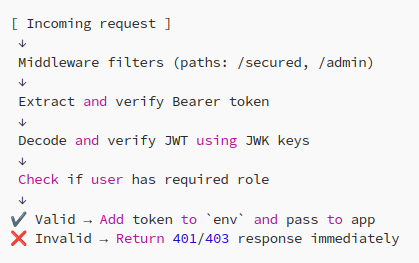
```
1.Rewraps the request using Rack::Request.
2.Checks if the path matches protected routes (/secured, /admin).
3.Extracts the Authorization header and ensures it starts with Bearer .
4.Decodes the token via decode_token(token).
5.Verifies if required_role exists in the token's realm_access.roles.
6.Rejects unauthorized access (401 or 403) if checks fail.
7.Stores token payload in env["keycloak.token"] if valid, then forwards the request.
```


In [1]:
require 'rubygems'
require 'rack'


true

#### 1.Rewraps the request using Rack::Request.
#### 2.Checks if the path matches protected routes (/secured, /admin).

In [2]:
require 'rack'
require 'stringio' # Needed to simulate rack.input

env = {
  "REQUEST_METHOD" => "GET",
  "PATH_INFO" => "/secured",
  "rack.input" => StringIO.new("Hello, Rack!")
}

request = Rack::Request.new(env)

puts request.path_info      # => "/"
puts request.request_method # => "GET"
puts request.env["rack.input"].read  # => "Hello, Rack!"

/secured
GET
Hello, Rack!


#### 

In [3]:
required_role = case env["PATH_INFO"]
when "/secured" then "user"
when "/admin"   then "admin"
else
  return @app.call(env)
end


"user"

```
🛠 Explanation @app.call() method

In Rack middleware, @app is expected to be another Rack application (usually the next middleware or your app). It must respond to .call(env).

You're likely testing this middleware outside the real Rack context, so @app was never initialized.
```

In [4]:
require 'rack'

class MyMiddleware
  def initialize(app)
    @app = app
  end

  def call(env)
    required_role = case env["PATH_INFO"]
    when "/secured" then "user"
    when "/admin"   then "admin"
    else
      return @app.call(env)
    end

    [200, { "Content-Type" => "text/plain" }, ["Required role: #{required_role}"]]
  end
end

# Dummy app to test middleware
app = ->(env) { [200, { "Content-Type" => "text/plain" }, ["Fallback App"]] }

# Wrap with middleware
middleware = MyMiddleware.new(app)

# Test environment
env = {
  "REQUEST_METHOD" => "GET",
  "PATH_INFO" => "/secured",
  "HTTP_AUTHORIZATION" => "Bearer mytoken123",
  "rack.input" => StringIO.new("")
}

# Call the middleware
status, headers, body = middleware.call(env)

puts "Status: #{status}"
puts "Headers: #{headers}"
puts "Body: #{body.join}"


Status: 200
Headers: {"Content-Type"=>"text/plain"}
Body: Required role: user


#### 3.Extracts the Authorization header and ensures it starts with Bearer .

In [5]:
request = Rack::Request.new(env)

# Correct usage
auth_header = request.get_header("HTTP_AUTHORIZATION")
puts auth_header  # => "Bearer mytoken123"

Bearer mytoken123


In [6]:
token = auth_header.split.last

"mytoken123"

```
Before we decode the token,
we need the JWT public keys. 
You can quickly retrieve them from the Keycloak realm’s OpenID Connect discovery endpoint, 
usually found at /realms/{realm-name}/.well-known/openid-configuration.```

Here's a simple and working Ruby code snippet that you can run in a Jupyter Notebook using IRuby to fetch the .well-known/openid-configuration from your Keycloak server:

In [7]:
require 'net/http'
require 'json'
require 'uri'
require 'pp'  # built-in pretty printer

# Replace with your actual Keycloak host and realm
keycloak_host = "http://localhost:8080"
realm_name = "quickstart"

# Build the URL
url = URI("#{keycloak_host}/realms/#{realm_name}/.well-known/openid-configuration")

# Make the GET request
response = Net::HTTP.get_response(url)

if response.is_a?(Net::HTTPSuccess)
  config = JSON.parse(response.body)

  puts "\n🔐 Keycloak OpenID Configuration:"
  puts "----------------------------------"
  puts "Issuer:             #{config['issuer']}"
  puts "Authorization URL:  #{config['authorization_endpoint']}"
  puts "Token URL:          #{config['token_endpoint']}"
  puts "JWKS URI:           #{config['jwks_uri']}"
  puts "\n📄 Full Configuration:\n"

  pp config  # Pretty-print with built-in pretty printer
else
  puts "❌ Failed to fetch configuration: #{response.code} #{response.message}"
end




🔐 Keycloak OpenID Configuration:
----------------------------------
Issuer:             http://localhost:8080/realms/quickstart
Authorization URL:  http://localhost:8080/realms/quickstart/protocol/openid-connect/auth
Token URL:          http://localhost:8080/realms/quickstart/protocol/openid-connect/token
JWKS URI:           http://localhost:8080/realms/quickstart/protocol/openid-connect/certs

📄 Full Configuration:
{"issuer"=>"http://localhost:8080/realms/quickstart",
 "authorization_endpoint"=>
  "http://localhost:8080/realms/quickstart/protocol/openid-connect/auth",
 "token_endpoint"=>
  "http://localhost:8080/realms/quickstart/protocol/openid-connect/token",
 "introspection_endpoint"=>
  "http://localhost:8080/realms/quickstart/protocol/openid-connect/token/introspect",
 "userinfo_endpoint"=>
  "http://localhost:8080/realms/quickstart/protocol/openid-connect/userinfo",
 "end_session_endpoint"=>
  "http://localhost:8080/realms/quickstart/protocol/openid-connect/logout",
 "frontchan

{"issuer"=>"http://localhost:8080/realms/quickstart", "authorization_endpoint"=>"http://localhost:8080/realms/quickstart/protocol/openid-connect/auth", "token_endpoint"=>"http://localhost:8080/realms/quickstart/protocol/openid-connect/token", "introspection_endpoint"=>"http://localhost:8080/realms/quickstart/protocol/openid-connect/token/introspect", "userinfo_endpoint"=>"http://localhost:8080/realms/quickstart/protocol/openid-connect/userinfo", "end_session_endpoint"=>"http://localhost:8080/realms/quickstart/protocol/openid-connect/logout", "frontchannel_logout_session_supported"=>true, "frontchannel_logout_supported"=>true, "jwks_uri"=>"http://localhost:8080/realms/quickstart/protocol/openid-connect/certs", "check_session_iframe"=>"http://localhost:8080/realms/quickstart/protocol/openid-connect/login-status-iframe.html", "grant_types_supported"=>["authorization_code", "implicit", "refresh_token", "password", "client_credentials", "urn:openid:params:grant-type:ciba", "urn:ietf:params:

#### What is this endpoint?

Great question! The `.well-known/openid-configuration` endpoint is a standard part of the `OpenID Connect (OIDC) Discovery protocol`, which **Keycloak fully supports**.

#### What is this endpoint?

    It is often called the OpenID Provider Configuration URL or Discovery Endpoint.

    URL pattern:
`https://<keycloak-host>/realms/<realm-name>/.well-known/openid-configuration`

    This endpoint provides a JSON document describing:
    
         . the OAuth2 / OpenID Connect endpoints, 
         . supported features, and 
         . important metadata for the Keycloak realm.

#### Why is it important?

    It allows clients (applications) to dynamically discover how to interact with the authentication server without hardcoding URLs.

    Clients can automatically learn:

         . Authorization endpoint URL
         . Token endpoint URL
         . User info endpoint URL
         . JWKS (JSON Web Key Set) URI — where to get public keys for token verification
         . Supported scopes, response types, and claims
         . Other OAuth2/OpenID Connect capabilities and policies


<h4>Key fields commonly found in this JSON:</h4>

<table style="text-align: left; margin-left: 0;">
  <thead>
    <tr>
      <th>Field Name</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr><td><code>issuer</code></td><td>The URL identifier for the issuer (realm)</td></tr>
    <tr><td><code>authorization_endpoint</code></td><td>URL where users are redirected for login</td></tr>
    <tr><td><code>token_endpoint</code></td><td>URL to exchange authorization code for tokens</td></tr>
    <tr><td><code>userinfo_endpoint</code></td><td>URL to get user profile info from access token</td></tr>
    <tr><td><code>jwks_uri</code></td><td>URL to fetch JSON Web Key Set (public keys)</td></tr>
    <tr><td><code>response_types_supported</code></td><td>List of supported OAuth2 response types</td></tr>
    <tr><td><code>scopes_supported</code></td><td>Supported OAuth2 scopes</td></tr>
    <tr><td><code>subject_types_supported</code></td><td>Supported subject identifier types</td></tr>
  </tbody>
</table>

#### How does this help developers?

    You don’t have to manually configure all URLs for your Keycloak realm in your app.

    Libraries like omniauth, oauth2-client, or passport.js use this endpoint to set themselves up automatically.

    It standardizes how OpenID Connect identity providers expose their info.

<h4>OpenID Discovery Summary:</h4>

<table style="text-align: left; margin-left: 0;">
  <thead>
    <tr>
      <th>Aspect</th>
      <th>Detail</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>Protocol</td><td>OpenID Connect Discovery</td></tr>
    <tr><td>Endpoint purpose</td><td>Dynamic config discovery</td></tr>
    <tr><td>Used by</td><td>Clients, SDKs, identity libraries</td></tr>
    <tr><td>Keycloak support</td><td>Full OIDC compliant</td></tr>
  </tbody>
</table>




#### 4.Decodes the token via decode_token(token).

To verify tokens, we must first fetch the public keys from the JWKS URI provided by the Keycloak realm:

`http://localhost:8080/realms/quickstart/protocol/openid-connect/certs`

```
"access_token": 
must have exactly 3 parts separated by dots:

<HEADER>.<PAYLOAD>.<SIGNATURE>```

IF EXPIRED IT RETURNS:

JWT::ExpiredSignature: Signature has expired
/var/lib/gems/3.2.0/gems/jwt-3.0.0/lib/jwt/claims/expiration.rb:24:in `verify!'
/var/lib/gems/3.2.0/gems/jwt-3.0.0/lib/jwt/claims/decode_verifier.rb:33:in `block in verify!'
/var/lib/gems/3.2.0/gems/jwt-3.0.0/lib/jwt/claims/decode_verifier.rb:30:in `each'
/var/lib/gems/3.2.0/gems/jwt-3.0.0/lib/jwt/claims/decode_verifier.rb:30:in `verify!'
/var/lib/gems/3.2.0/gems/jwt-3.0.0/lib/jwt/decode.rb:41:in `decode_segments'
/var/lib/gems/3.2.0/gems/jwt-3.0.0/lib/jwt.rb:46:in `decode'
(irb):29:in `<top (required)>'

In [8]:
require 'jwt'


true

#### What follows is a real access_token retrieved using Postman:

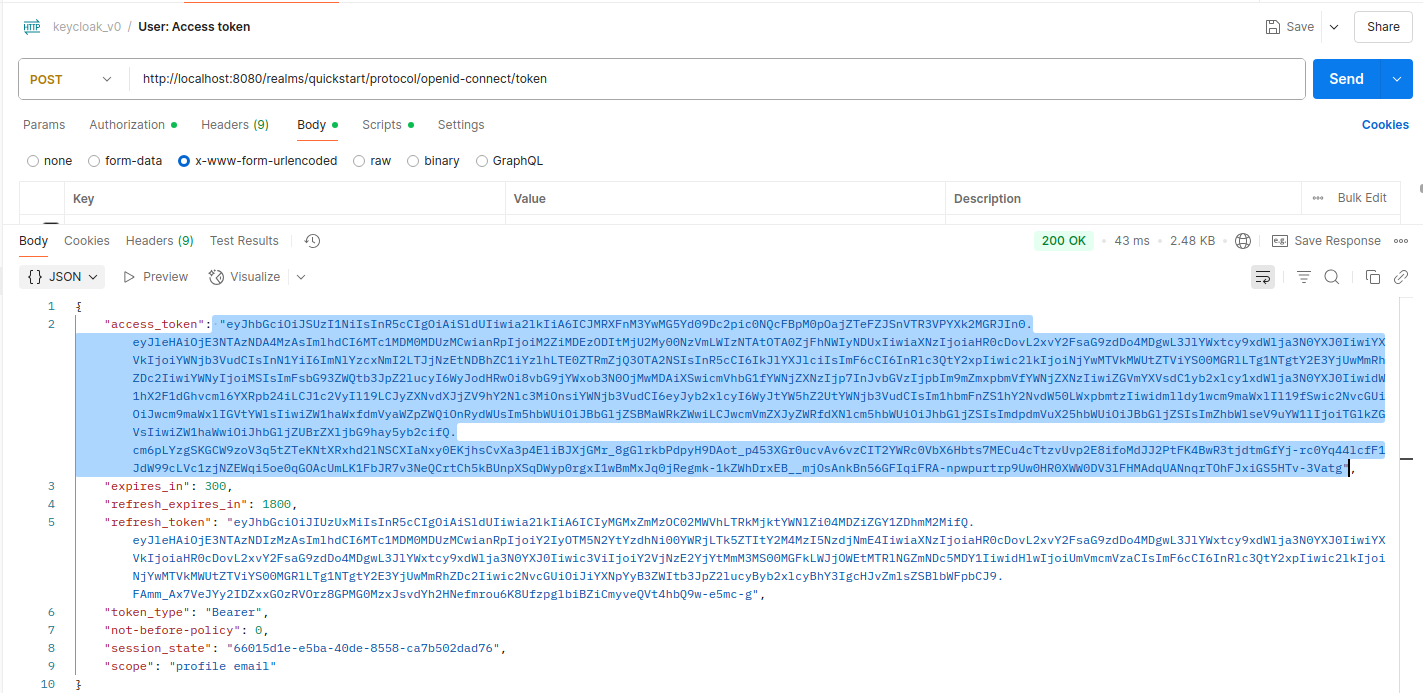

<p>see 👉️ <a href="https://documenter.getpostman.com/view/1017517/2sB2x5Frhq" target="_blank">API Docs</a></p>


In [9]:
access_token =  "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJMRXFnM3YwMG5Yd09Dc2pic0NQcFBpM0pOajZTeFZJSnVTR3VPYXk2MGRJIn0.eyJleHAiOjE3NTAzNDQ0MDgsImlhdCI6MTc1MDM0NDEwOCwianRpIjoiNGViNDM3ZTItMjMyMi00YmExLTgyYjMtODM5YjY2NjJhMDBlIiwiaXNzIjoiaHR0cDovL2xvY2FsaG9zdDo4MDgwL3JlYWxtcy9xdWlja3N0YXJ0IiwiYXVkIjoiYWNjb3VudCIsInN1YiI6ImNlYzcxNmI2LTJjNzEtNDBhZC1iYzlhLTE0ZTRmZjQ3OTA2NSIsInR5cCI6IkJlYXJlciIsImF6cCI6InRlc3QtY2xpIiwic2lkIjoiNDBiNTVhYTEtMTI3OC00OWJmLWI0YzEtZGY4ZTIzYmZjMWFiIiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwOi8vbG9jYWxob3N0OjMwMDAiXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwiZGVmYXVsdC1yb2xlcy1xdWlja3N0YXJ0IiwidW1hX2F1dGhvcml6YXRpb24iLCJ1c2VyIl19LCJyZXNvdXJjZV9hY2Nlc3MiOnsiYWNjb3VudCI6eyJyb2xlcyI6WyJtYW5hZ2UtYWNjb3VudCIsIm1hbmFnZS1hY2NvdW50LWxpbmtzIiwidmlldy1wcm9maWxlIl19fSwic2NvcGUiOiJwcm9maWxlIGVtYWlsIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsIm5hbWUiOiJBbGljZSBMaWRkZWwiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJhbGljZSIsImdpdmVuX25hbWUiOiJBbGljZSIsImZhbWlseV9uYW1lIjoiTGlkZGVsIiwiZW1haWwiOiJhbGljZUBrZXljbG9hay5yb2cifQ.x-u3OZGgOcPdlIwAubzwB5HLCQFjoJo46WSbg-5jCCk7IKULtwO3sVppU877SGvzA7WKw1ih_0bvVb4aadrNNF3j_wk2ncAu8RoK13RpAFDvtrLGBPejGmop-YcKiXoYpsmzWIrS4xuZE6LfxP9UrJSWUOQHzPmHz5uIYsnEKpEQM3VfMC04JgwXAzQ_40Fz0vQyPsp7ORM9GvyBfkYgPObgNXi--jGB94QVONME5z0eeYVs5AVLfEZbguPlwT2I3hp4pCeBqIVkou5KV5BKpgFZGG8PBmNkdD14Ycn1vogTGrvYU7bzbj8sdKKeh1lB7ynEIaFP0znShTq5aGWggA"

"eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJMRXFnM3YwMG5Yd09Dc2pic0NQcFBpM0pOajZTeFZJSnVTR3VPYXk2MGRJIn0.eyJleHAiOjE3NTAzNDQ0MDgsImlhdCI6MTc1MDM0NDEwOCwianRpIjoiNGViNDM3ZTItMjMyMi00YmExLTgyYjMtODM5YjY2NjJhMDBlIiwiaXNzIjoiaHR0cDovL2xvY2FsaG9zdDo4MDgwL3JlYWxtcy9xdWlja3N0YXJ0IiwiYXVkIjoiYWNjb3VudCIsInN1YiI6ImNlYzcxNmI2LTJjNzEtNDBhZC1iYzlhLTE0ZTRmZjQ3OTA2NSIsInR5cCI6IkJlYXJlciIsImF6cCI6InRlc3QtY2xpIiwic2lkIjoiNDBiNTVhYTEtMTI3OC00OWJmLWI0YzEtZGY4ZTIzYmZjMWFiIiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwOi8vbG9jYWxob3N0OjMwMDAiXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwiZGVmYXVsdC1yb2xlcy1xdWlja3N0YXJ0IiwidW1hX2F1dGhvcml6YXRpb24iLCJ1c2VyIl19LCJyZXNvdXJjZV9hY2Nlc3MiOnsiYWNjb3VudCI6eyJyb2xlcyI6WyJtYW5hZ2UtYWNjb3VudCIsIm1hbmFnZS1hY2NvdW50LWxpbmtzIiwidmlldy1wcm9maWxlIl19fSwic2NvcGUiOiJwcm9maWxlIGVtYWlsIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsIm5hbWUiOiJBbGljZSBMaWRkZWwiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJhbGljZSIsImdpdmVuX25hbWUiOiJBbGljZSIsImZhbWlseV9uYW1lIjoiTGlkZGVsIiwiZW1haWwiOiJ

In [10]:
require 'jwt'
require 'json'
require 'net/http'
require 'uri'
require 'openssl'
require 'json/jwt'  # For converting JWK to OpenSSL::PKey

# Your JWT token (already copied)
access_token  =  access_token

# 1. Decode header (without verification) to get the `kid`,the key ID
header = JWT.decode(access_token, nil, false).last
kid = header['kid']

# 2. Fetch JWKS from Keycloak
jwks_uri = URI("http://localhost:8080/realms/quickstart/protocol/openid-connect/certs")
response = Net::HTTP.get_response(jwks_uri)
jwks = JSON.parse(response.body)

# 3. Find the matching JWK by `kid`
jwk_data = jwks['keys'].find { |key| key['kid'] == kid }

raise "No matching JWK found" unless jwk_data

# 4. Convert to RSA public key
jwk = JSON::JWK.new(jwk_data)
public_key = jwk.to_key  # => OpenSSL::PKey::RSA instance

# 5. Verify and decode JWT
payload = JWT.decode(access_token, public_key, true, { algorithm: 'RS256' }).first

# 6. Print decoded payload
puts "✅ Decoded JWT payload:"
pp payload


✅ Decoded JWT payload:
{"exp"=>1750344408,
 "iat"=>1750344108,
 "jti"=>"4eb437e2-2322-4ba1-82b3-839b6662a00e",
 "iss"=>"http://localhost:8080/realms/quickstart",
 "aud"=>"account",
 "sub"=>"cec716b6-2c71-40ad-bc9a-14e4ff479065",
 "typ"=>"Bearer",
 "azp"=>"test-cli",
 "sid"=>"40b55aa1-1278-49bf-b4c1-df8e23bfc1ab",
 "acr"=>"1",
 "allowed-origins"=>["http://localhost:3000"],
 "realm_access"=>
  {"roles"=>
    ["offline_access",
     "default-roles-quickstart",
     "uma_authorization",
     "user"]},
 "resource_access"=>
  {"account"=>
    {"roles"=>["manage-account", "manage-account-links", "view-profile"]}},
 "scope"=>"profile email",
 "email_verified"=>true,
 "name"=>"Alice Liddel",
 "preferred_username"=>"alice",
 "given_name"=>"Alice",
 "family_name"=>"Liddel",
 "email"=>"alice@keycloak.rog"}


{"exp"=>1750344408, "iat"=>1750344108, "jti"=>"4eb437e2-2322-4ba1-82b3-839b6662a00e", "iss"=>"http://localhost:8080/realms/quickstart", "aud"=>"account", "sub"=>"cec716b6-2c71-40ad-bc9a-14e4ff479065", "typ"=>"Bearer", "azp"=>"test-cli", "sid"=>"40b55aa1-1278-49bf-b4c1-df8e23bfc1ab", "acr"=>"1", "allowed-origins"=>["http://localhost:3000"], "realm_access"=>{"roles"=>["offline_access", "default-roles-quickstart", "uma_authorization", "user"]}, "resource_access"=>{"account"=>{"roles"=>["manage-account", "manage-account-links", "view-profile"]}}, "scope"=>"profile email", "email_verified"=>true, "name"=>"Alice Liddel", "preferred_username"=>"alice", "given_name"=>"Alice", "family_name"=>"Liddel", "email"=>"alice@keycloak.rog"}

#### 5.Verifies if required_role exists in the token's realm_access.roles.

#### 7.Stores token payload in env["keycloak.token"] if valid, then forwards the request.

#### Note
```
While we have access to the entire user payload, returning the user's roles is sufficient for this middleware implementation. This applies equally to admin users:
```

In [11]:
roles = payload.dig("realm_access", "roles") || []

["offline_access", "default-roles-quickstart", "uma_authorization", "user"]

#### Note
```
If needed, we can easily return the full user profile as well.
```

In [12]:
user_info = {
  name:                payload["name"],
  email:               payload["email"],
  preferred_username:  payload["preferred_username"],
  given_name:          payload["given_name"],
  family_name:         payload["family_name"]
}

user_info.each do |key, value|
  puts "#{key.to_s.ljust(20)}: #{value || '[not provided]'}"
end


name                : Alice Liddel
email               : alice@keycloak.rog
preferred_username  : alice
given_name          : Alice
family_name         : Liddel


{:name=>"Alice Liddel", :email=>"alice@keycloak.rog", :preferred_username=>"alice", :given_name=>"Alice", :family_name=>"Liddel"}

#### 6.Rejects unauthorized access (401 or 403) if checks fail.

In [13]:
def unauthorized(message)
      [401, { "Content-Type" => "application/json" }, [{ error: message }.to_json]]
end


def forbidden(message)
  [403, { "Content-Type" => "application/json" }, [{ error: message }.to_json]]
end


:forbidden

In [14]:
# Example setup (so this cell works independently)
roles = ["user", "viewer"]
required_role = "admin"

def forbidden(message)
  puts "❌ Access Denied: #{message}"
  # Optionally return a Rack response or raise an exception
  # [403, { "Content-Type" => "text/plain" }, [message]]
end

unless roles.include?(required_role)
  forbidden("Insufficient role")
end


❌ Access Denied: Insufficient role


In [15]:
puts "This document provides a clear explanation of the middleware implemented by J3.
Please review and be aware of this update.
Best regards."

This document provides a clear explanation of the middleware implemented by J3.
Please review and be aware of this update.
Best regards.
